In [29]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pysumma.plotting as psp
import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd
import pysumma as ps

# function to convert summa 
def convert_time_to_summa_string(t):
    return (
        f'{t.dt.year.values[()]:04}'
        f'-{t.dt.month.values[()]:02}'
        f'-{t.dt.day.values[()]:02}'
        f' {t.dt.hour.values[()]:02}'
        f':{t.dt.minute.values[()]:02}'
    )
# set up attributes for forcing data
attrs = {
   'airpres':  {'units': 'Pa', 'long_name': 'Air pressure'},
   'airtemp':  {'units': 'K', 'long_name': 'Air temperature'},
   'spechum':  {'units': 'g g-1', 'long_name': 'Specific humidity'},
   'windspd':  {'units': 'Wind speed', 'long_name': 'm s-1'},
   'SWRadAtm': {'units': 'W m-2', 'long_name': 'Downward shortwave radiation'},
   'LWRadAtm': {'units': 'W m-2', 'long_name': 'Downward longwave radiation'},
   'pptrate':  {'units': 'kg m-2 s-1', 'long_name': 'Precipitation rate'}
}
name_lookup = {
    'airpres':  'pressure',
    'airtemp':  'temperature',
    'spechum':  'specific_humidity',
    'windspd':  'windspeed',
    'SWRadAtm': 'shortwave_radiation',
    'LWRadAtm': 'longwave_radiation',
    'pptrate':  'total_precipitation',
}

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# open forcing netcdf - 'hj_andrews_wy2021.nc' Where is this file written from the csv?
df2 = xr.open_dataset('/Users/ianwhidden/pysumma/pysumma/workspace_HJA_pysumma/hjandrews_summa_setup/forcings/hj_andrews_wy2021.nc').load()
df2

<xarray.Dataset>
Dimensions:    (time: 8736, hru: 1)
Coordinates:
  * time       (time) datetime64[ns] 2021-10-01T01:00:00 ... 2022-09-30
Dimensions without coordinates: hru
Data variables:
    airpres    (time, hru) float64 9.236e+04 9.238e+04 ... 9.241e+04 9.24e+04
    airtemp    (time, hru) float64 291.1 289.9 288.7 287.5 ... 289.3 289.2 289.1
    spechum    (time, hru) float64 0.008863 0.009004 ... 0.008456 0.008265
    windspd    (time, hru) float64 3.463 2.985 2.576 2.26 ... 2.349 1.91 1.863
    SWRadAtm   (time, hru) float64 114.5 51.91 0.0 0.0 ... 491.8 429.3 340.2
    LWRadAtm   (time, hru) float64 362.8 362.8 362.9 356.9 ... 339.8 339.8 339.8
    pptrate    (time, hru) float64 0.0 0.0 0.0 ... 9.333e-06 2.706e-05 9.278e-06
    data_step  float64 3.6e+03

In [17]:
# data from NLDAS for 10/1/21 0:00 to 9/29/22 23:00
# downscaled data from NLDAS for 10/2/21 0:00 to 7/31/22 00:00
# read in met data to pd df
df = pd.read_csv('../NLDAS2_WY22.csv')
# create date time index, which somehow tells summa that this column in the df is the time object/index to use?
df.index = pd.DatetimeIndex(df['time_convert'], name='time')
# Ask Andrew about code in this section. How does the df turn into a netCDF here?
forcing_filename = 'hj_andrews_wy2021.nc'
# Adding 1 hour to account for SUMMA being period-ending
time_idx = df.index + pd.Timedelta('1H')
shape = (len(time_idx), 1, )
dims = ('time', 'hru', )
coords = {'time': time_idx}

met_data = xr.Dataset(coords=coords)
met_data.time.encoding['calendar'] = 'standard'
met_data.time.encoding['units'] = 'hours since 2021-10-01'
for varname, varattrs in attrs.items():
    df_name = name_lookup[varname]
    met_data[varname] = xr.DataArray(
        data=df[df_name].values.reshape(-1, 1),
        coords=coords, dims=dims, name=varname, attrs=varattrs
    )

met_data['airtemp'] += 273.16  # Convert to Kelvin
met_data['pptrate'] /= 3600.0  # Convert to mm/s
met_data['data_step'] = xr.Variable([], 3600.0)
met_data.to_netcdf(f'./forcings/{forcing_filename}')

with open('./forcings/forcing_file_list.txt', 'w') as f:
    f.write(f"'{forcing_filename}'\n")

In [20]:
lat = 44.2072180256268
lon = -122.119450090239
elev = 1300
# open local_attributes.nc
local_attrs = xr.open_dataset('../summa_setup_template/params/local_attributes.nc').load()
# Update local_attributes with desired values
local_attrs['longitude'].values[:] = lon
local_attrs['latitude'].values[:] = lat
local_attrs['elevation'].values[:] = elev
# 1 is evergreen needleleaf forest in the MODIFIED_IGBP_MODIS_NOAH option
# for the `vegeParTbl` decision. This can be found in the `VEGPARM.TBL` file
# 16 is Barren or Sparsely Vegetated'
local_attrs['vegTypeIndex'].values[:] = 1
local_attrs.to_netcdf('./params/local_attributes.nc')

In [8]:
local_attrs

<xarray.Dataset>
Dimensions:         (hru: 1, gru: 1)
Dimensions without coordinates: hru, gru
Data variables: (12/14)
    hruId           (hru) int32 1001
    gruId           (gru) int32 1001
    hru2gruId       (hru) int32 1001
    downHRUindex    (hru) int32 0
    longitude       (hru) float64 -122.1
    latitude        (hru) float64 44.21
    ...              ...
    tan_slope       (hru) float64 0.2
    contourLength   (hru) float64 100.0
    slopeTypeIndex  (hru) int32 1
    soilTypeIndex   (hru) int32 8
    vegTypeIndex    (hru) int32 1
    mHeight         (hru) float64 4.0
Attributes:
    history:  Converted to NetCDF using "../../tools/localAttributes_ascii_to...

In [21]:
!./install_local_setup.sh

summa_exe = 'summa.exe'
file_manager = './file_manager.txt'
s = ps.Simulation(summa_exe, file_manager)

In [22]:
"""
!./install_local_setup.sh

summa_exe = 'summa.exe'
file_manager = './file_manager.txt'
s = ps.Simulation(summa_exe, file_manager)
"""

# modify output here. I place some in the cell below.

# Ask Andrew
t0 = met_data['time'].isel(time=0)
t1 = met_data['time'].isel(time=-1)
s.manager['simStartTime'] = convert_time_to_summa_string(t0)
s.manager['simEndTime'] = convert_time_to_summa_string(t1)

# Add a variable written to the output control file
s.output_control['scalarSnowDepth'] = [1, 0, 1, 0, 0, 0, 0, 0]

"""
s.run('local')
s.status
#print(s.stderr)
"""

"\ns.run('local')\ns.status\n#print(s.stderr)\n"

In [23]:

#s.global_hru_params

# Max albedo of 0.85 comes from Andreadis et al., 2009
# s.global_hru_params['albedoMax'] = 0.85
# print(s.global_hru_params['albedoMax'])

# roughness length of canopy (m)
#s.global_hru_params['z0Canopy'] = 

# zero plane displacement / canopy height (-)
s.global_hru_params['zpdFraction'] = 0.0

# height of top of the vegetation canopy above ground 
s.global_hru_params['heightCanopyTop'] = 0.0
# height of bottom of the vegetation canopy above ground surface (m)
s.global_hru_params['heightCanopyBottom'] = 0.0


# Decisions
# Andreadis et al. 2009 Includes a rapid interception increase between -3 and 0 C
# from observations of increased cohesion in warm regions.
s.decisions['snowIncept']= 'stickySnow'
#s.decisions['canopySrad']= 
#s.decisions['snowLayers']= 
#s.decisions['thCondSnow']= 

In [24]:
print(s.decisions['snowIncept'])
print(s.global_hru_params['albedoMax'])
print(s.global_hru_params['z0Canopy'])

#print(s.decisions['snowDenNew'])
#s.decisions
#s.decisions['snowDenNew']=True

snowIncept    stickySnow           ! choice of parameterization for snow interception
albedoMax                 |       0.8400 |       0.7000 |       0.9500
z0Canopy                  |       0.1000 |       0.0010 |      10.0000


In [25]:
print(s.global_hru_params['z0Canopy'])
print(s.global_hru_params['zpdFraction'])
print(s.global_hru_params['heightCanopyTop'])
print(s.global_hru_params['heightCanopyBottom'])

print(s.global_hru_params['albedoMax'])
print(s.global_hru_params['albedoDecayRate'])
print(s.global_hru_params['albedoRefresh'])

print(s.global_hru_params['Frad_direct'])
print(s.global_hru_params['Frad_vis'])

z0Canopy                  |       0.1000 |       0.0010 |      10.0000
zpdFraction               |       0.0000 |       0.0000 |       0.0000
heightCanopyTop           |       0.0000 |       0.0000 |       0.0000
heightCanopyBottom        |       0.0000 |       0.0000 |       0.0000
albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoDecayRate           |       1.0d+6 |       1.0d+5 |       5.0d+6
albedoRefresh             |       1.0000 |       1.0000 |      10.0000
Frad_direct               |       0.9000 |       0.0000 |       1.0000
Frad_vis                  |       0.9000 |       0.0000 |       1.0000


In [26]:
s.run('local')
s.status
#print(s.stderr)

'Success'

In [27]:
#s.reset()
# %reset
#s.output_control

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


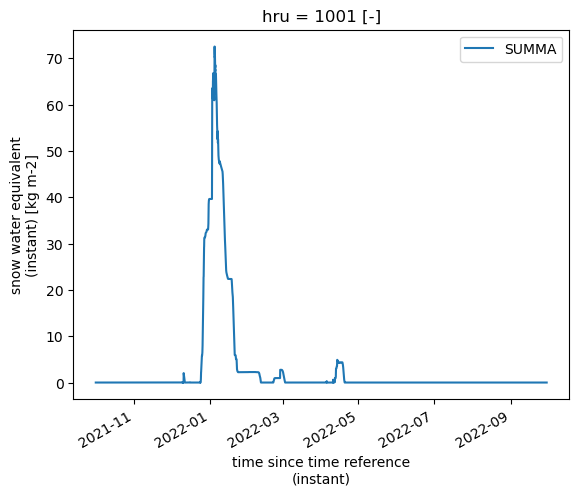

In [21]:
# print(s.global_hru_params)

# plot for SWE

s.output['scalarSWE'].plot(label='SUMMA');
#s.output['scalarSnowDepth'].plot(label='SUMMA');
plt.legend();

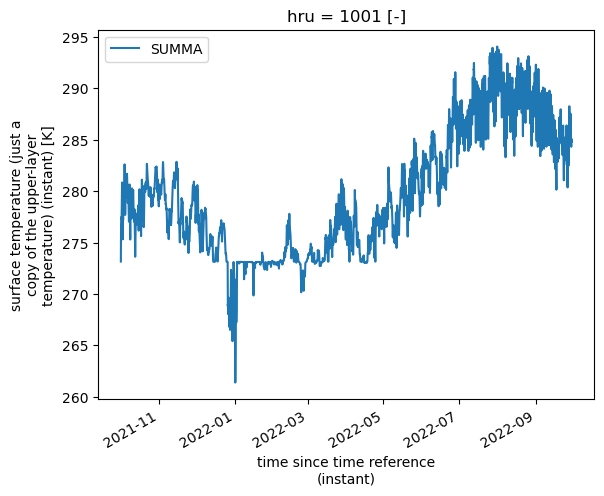

In [23]:
# plot for something else

s.output['scalarSurfaceTemp'].plot(label='SUMMA');
#s.output['scalarSnowDepth'].plot(label='SUMMA');
plt.legend();


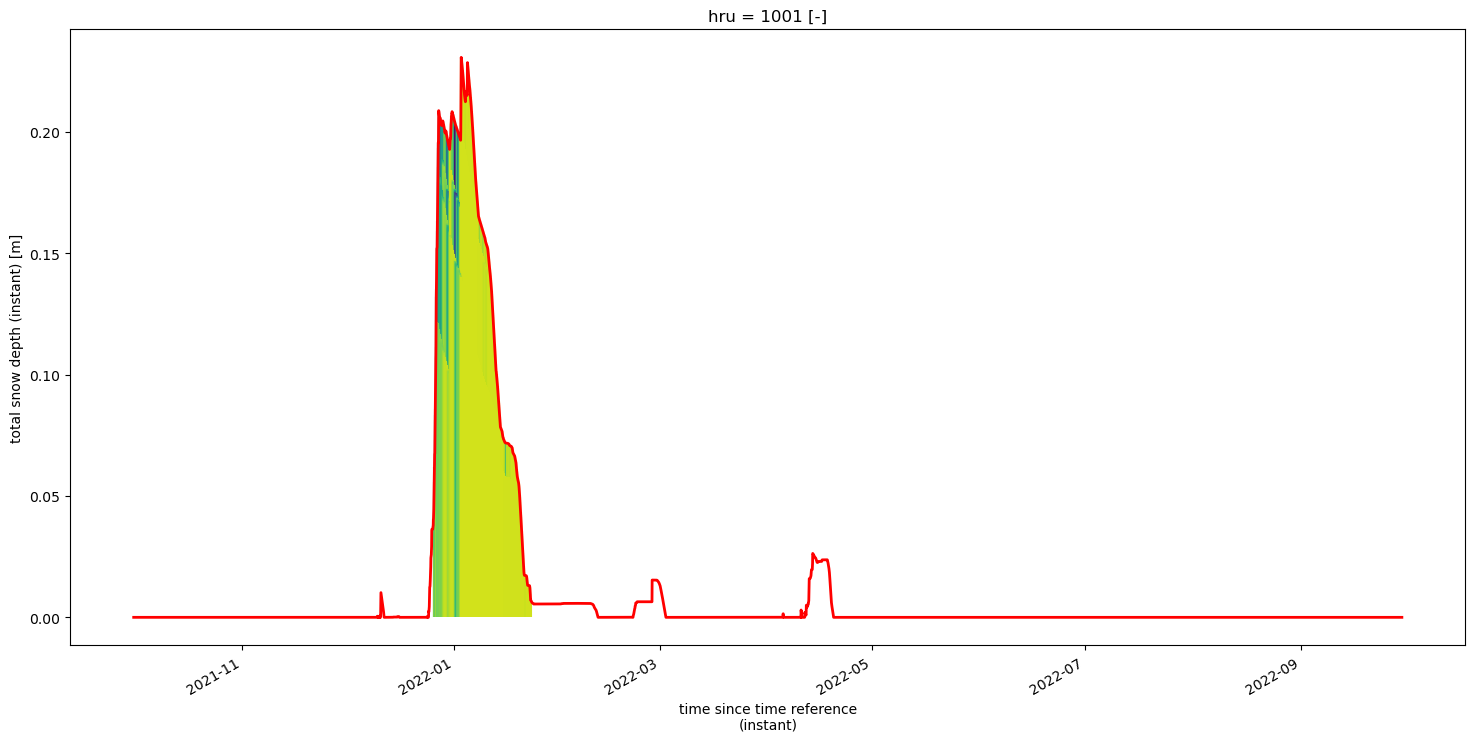

In [38]:
# Total snow depth
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);


In [ ]:
# Volumetric water content

psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=True);
#s.output['scalarSnowDepth'].plot(color='red', linewidth=2);

# Change what is written in s.output_control (txt)

In [ ]:
# Add a variable written to output

"""s.output_control['scalarSnowDepth'] = {
    'period': 1, 'instant': 1, 'sum': 0, 
    'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
    """
#s.output_control['scalarSnowDepth']


## s.decisions (txt)

In [106]:
#print(s.decisions)

soilCatTbl    ROSETTA              ! soil-category dataset
vegeParTbl    MODIFIED_IGBP_MODIS_NOAH ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    BallBerryFlex        ! choice of function for stomatal resistance
bbTempFunc    q10Func              ! Ball-Berry: leaf temperature controls on photosynthesis + stomatal resistance
bbHumdFunc    humidLeafSurface     ! Ball-Berry: humidity controls on stomatal resistance
bbElecFunc    quadraticJmax        ! Ball-Berry: dependence of photosynthesis on PAR
bbCO2point    Leuning              ! Ball-Berry: use of CO2 compensation point to calculate stomatal resistance
bbAssimFnc    colimitation         ! Ball-Berry: controls on carbon assimilation
bbCanIntg8    laiScaling           ! Ball-Berry: scaling of photosynthesis from the leaf to the canopy
bbNumerics    newtonRaphson        ! Ball-Berry: iterative numerical solution method
num_method  

In [ ]:
# Get just the `snowIncept` option
#print(s.decisions['snowIncept'])
#print(s.decisions['windPrfile'])

print(s.decisions['windPrfile'].available_options)

# Change the value of a decision example
#s.decisions['snowIncept'] = 'stickySnow'
#print(s.decisions['snowIncept'])